<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import dates
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import scipy.interpolate as interpolate
from scipy.stats.mstats import scoreatpercentile
import scipy.stats as stats
from scipy.stats import pearsonr
import pandas as pd
import os,subprocess,time,copy
import scipy
import datetime
import matplotlib.gridspec as gridspec
#import pyart.graph.cm as pcm
#import cPickle as pickle
#import pickle
#import pprint
#import triangle
import corner
#import f90nml
%matplotlib inline

In [2]:
from marcus_py_tools import make_edge_vec, xy_from_latlon, latlon_from_xy, walklevel, find_stuff_at_level,haversine

ModuleNotFoundError: No module named 'pyproj'

In [2]:
import re

In [3]:
def walklevel(some_dir, level=1):
    some_dir = some_dir.rstrip(os.path.sep)
    assert os.path.isdir(some_dir)
    num_sep = some_dir.count(os.path.sep)
    for root, dirs, files in os.walk(some_dir):
      yield root, dirs, files
      num_sep_this = root.count(os.path.sep)
      if num_sep + level <= num_sep_this:
        del dirs[:]

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [204]:
case = 'dycoms'
#case = 'bomex'
#case = 'rico'
#case = 'sct'
case_upper = case.upper()

#main_dir = '/home/marcus/marcus_data/E3SM_BOSS_PPE_data/GISS_SCM_PPE/dycoms/'
main_dir = '/data/gelsaess/giss-e3scm-ppe-elsaesser/'+case+'/'
#main_dir = '/Users/marcus/Research/Elsaesser_NASA/SCM_PPE/'+case+'/'
subdir_list = []
num_subdir  = 0
for root,dirs,files in walklevel(main_dir,level=0):
    for dirr in dirs:
        #if dirr.startswith('SCM_'+case_upper+'_jingbo'):
        if dirr.startswith('SCM_'+case_upper+'_gse'):
            subdir_list.append(dirr)
            num_subdir += 1
subdir_list = sorted(subdir_list)
subdir_list = subdir_list[1:]
num_subdir -= 1
print(num_subdir,subdir_list[-1])

850 SCM_DYCOMS_gse850F110


In [205]:
#..Pick one. First see if we can read parameters
par_dict = {}
pars = []
parnames = list()
with open(main_dir+subdir_list[420]+'/I') as myfile:
    for myline in myfile:
        if (myline[0]==' '):
            pass
        else:
            r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
            for name,val in r:
                if val:
                    pars = np.r_[pars,float(val)]
                parnames = parnames + [name]
            idict={name:float(val) for name,val in r}
            par_dict.update(idict)

In [206]:
print(par_dict)
print(pars.shape)
print(len(parnames))

{'debdecaytime': 2150.66, 'mc': 42.159, 'xs': 110.259, 'qc': 0.000122477, 'multiplier': 0.639139, 'mstcnv': 10.6449, '': 3.31033, 'urelscale': 65.1935, 'dpscale': 64.3072, 'scale': 0.000714371, 'fevapfac': 0.0327813, 'fac': 1.00092, 'max': 113.406, 'detbyent': 0.357525, 'dd': 5.68312e-05, 'overshoot': 0.270718, 'aspcp': 0.139813, 'fddrt': 0.60429, 'tfmc': 255.196, 'env': 5.26882, 'homf': 237.609, 'rhcsl': 0.833764, 'rhctl': 0.932526, 'homfree': 239960.0, 'dcs': 0.000351213, 'rh': 0.970603, 'pow': 0.212904, 'time': 3553.15, 'cn': 0.838203, 'iifn': 8.71985, 'difn': 8.76673, 'ifluffy': 0.19737, 'sfluffy': 0.612629, 'multi': 0.854739, 'mults': 1.25661, 'entrain': 15.1426}
(45,)
45


In [207]:
print(parnames)

['debdecaytime', 'mc', 'xs', 'qc', 'multiplier', 'mstcnv', 'mstcnv', '', '', 'urelscale', 'dpscale', '', '', '', '', 'scale', 'fevapfac', 'fac', 'max', 'fac', 'max', 'detbyent', 'dd', 'overshoot', 'aspcp', 'fac', 'fddrt', 'tfmc', 'env', 'homf', 'rhcsl', 'rhctl', 'homfree', 'dcs', 'rh', 'pow', 'time', 'cn', 'iifn', 'difn', 'ifluffy', 'sfluffy', 'multi', 'mults', 'entrain']


In [208]:
#.. Now let's make a plot or two
idx = 500
#nc = Dataset(main_dir+subdir_list[idx]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(idx+1).zfill(3)+'F110.nc','r')
nc = Dataset(main_dir+subdir_list[idx]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(idx+1).zfill(3)+'F110.nc','r')
time = nc.variables['time'][:]
prec = nc.variables['prec'][:,0,0]
lwp  = nc.variables['lwp'][:,0,0]
nc.close()


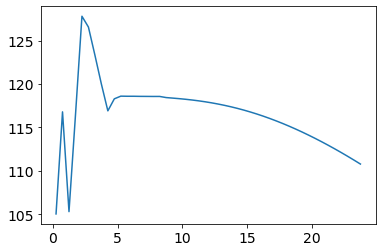

In [209]:
plt.plot(time,lwp)

In [210]:
print(time.shape)

(48,)


In [211]:
numpar = 45
num_main_ppe = 550
nt     = time.shape[0]
allpar = np.zeros((numpar,num_main_ppe))
all_prec = np.zeros((nt,num_main_ppe))
all_lwp  = np.zeros((nt,num_main_ppe))
all_cldtot = np.zeros((nt,num_main_ppe))  #..Total cloud fraction
all_cnvcld = np.zeros((nt,num_main_ppe))  #..convective cloud fraction
all_strcld = np.zeros((nt,num_main_ppe))  #..stratiform cloud fraction
all_olr = np.zeros((nt,num_main_ppe))
#..
num_post = 200
allpar_post = np.zeros((numpar,num_post))
all_prec_post = np.zeros((nt,num_post))
all_lwp_post  = np.zeros((nt,num_post))
all_cldtot_post = np.zeros((nt,num_post))
all_cnvcld_post = np.zeros((nt,num_post))
all_strcld_post = np.zeros((nt,num_post))
all_olr_post = np.zeros((nt,num_post))

#..Now do this for all ensemble members
for i in range(num_main_ppe):
    #..Pick one. First see if we can read parameters
    par_dict = {}
    pars = []
    parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars = np.r_[pars,float(val)]
                    parnames = parnames + [name]
                idict={name:float(val) for name,val in r}
                par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    time = nc.variables['time'][:]
    prec = nc.variables['prec'][:,0,0]
    lwp  = nc.variables['lwp'][:,0,0]
    cldtot = nc.variables['cldtot_2d'][:,0,0]
    #cnvcld = nc.variables['cldmc_2d'][:,0,0]
    #strcld = nc.variables['cldss_2d'][:,0,0]
    cnvcld = nc.variables['tau_mc'][:,0,0]
    strcld = nc.variables['tau_ss'][:,0,0]
    nc.close()
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    olr  = nc.variables['olr'][:,0,0]
    nc.close()
    #
    allpar[:,i]   = pars
    all_prec[:,i] = prec
    all_lwp[:,i]  = lwp
    all_cldtot[:,i] = cldtot
    all_cnvcld[:,i] = cnvcld
    all_strcld[:,i] = strcld
    all_olr[:,i]  = olr
    
#..Now do this for all ensemble members
ii = 0
for i in range(num_main_ppe+100,num_subdir):
    #..Pick one. First see if we can read parameters
    #par_dict = {}
    pars_post = []
    #parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars_post = np.r_[pars_post,float(val)]
                    #parnames = parnames + [name]
                #idict={name:float(val) for name,val in r}
                #par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    time = nc.variables['time'][:]
    prec_post = nc.variables['prec'][:,0,0]
    lwp_post  = nc.variables['lwp'][:,0,0]
    cldtot_post = nc.variables['cldtot_2d'][:,0,0]
    #cnvcld_post = nc.variables['cldmc_2d'][:,0,0]
    #strcld_post = nc.variables['cldss_2d'][:,0,0]
    cnvcld_post = nc.variables['tau_mc'][:,0,0]
    strcld_post = nc.variables['tau_ss'][:,0,0]
    nc.close()
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    olr_post  = nc.variables['olr'][:,0,0]
    nc.close()
    #
    allpar_post[:,ii]   = pars_post
    all_prec_post[:,ii] = prec_post
    all_lwp_post[:,ii]  = lwp_post
    all_cldtot_post[:,ii] = cldtot_post
    all_cnvcld_post[:,ii] = cnvcld_post
    all_strcld_post[:,ii] = strcld_post
    all_olr_post[:,ii]  = olr_post
    ii += 1

In [212]:
#..Cacalate 90th, 50th, 10th percentile
pctiles = [90,50,10]
lwp_pct  = np.percentile(all_lwp,pctiles,axis=1)
prec_pct = np.percentile(all_prec,pctiles,axis=1)
cldt_pct = np.percentile(all_cldtot,pctiles,axis=1)
olr_pct  = np.percentile(all_olr,pctiles,axis=1)
cnv_pct  = np.percentile(all_cnvcld,pctiles,axis=1)
str_pct  = np.percentile(all_strcld,pctiles,axis=1)
print(lwp_pct.shape)
#..
lwp_pct_post  = np.percentile(all_lwp_post,pctiles,axis=1)
prec_pct_post = np.percentile(all_prec_post,pctiles,axis=1)
cldt_pct_post = np.percentile(all_cldtot_post,pctiles,axis=1)
olr_pct_post  = np.percentile(all_olr_post,pctiles,axis=1)
cnv_pct_post  = np.percentile(all_cnvcld_post,pctiles,axis=1)
str_pct_post  = np.percentile(all_strcld_post,pctiles,axis=1)
print(lwp_pct_post.shape)

(3, 48)
(3, 48)


In [213]:
print(all_lwp_post.shape)

(48, 200)


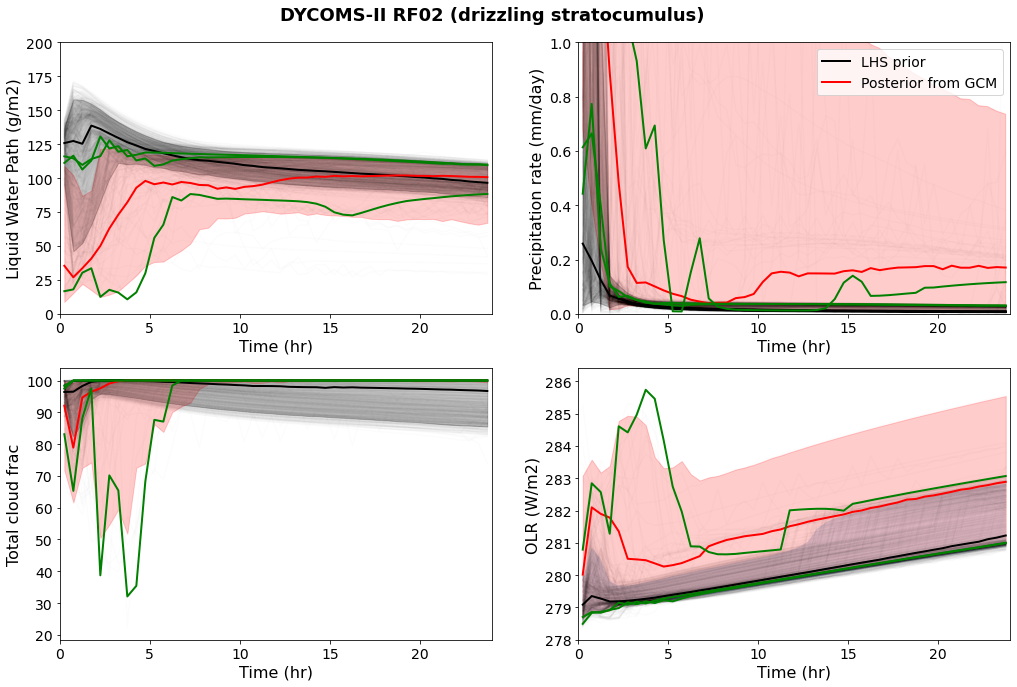

In [214]:
maxt = 24
max_contau=150.
max_strtau = .5
ig1 = 698-1-650
ig2 = 705-1-650
ig3 = 788-1-650

if (case=='rico' or case=='bomex'):
    fig = plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(3,2)
    max_lwp = 100.
    max_prec = 3.
elif (case=='sct'):
    fig = plt.figure(figsize=(15,15))
    #fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(3,2)
    #gs = gridspec.GridSpec(2,2)
    max_lwp = 150.
    max_prec = 3.
    maxt=72
    max_contau=30.
    max_strtau = .01
else:
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(2,2)
    max_lwp = 200.
    max_prec = 1.
#
ax = fig.add_subplot(gs[0])
stuff = ax.plot(time,all_lwp,'k',alpha=.01)
ax.fill_between(time, lwp_pct[2,:], lwp_pct[0,:],color='k', alpha=0.2)
ax.plot(time,lwp_pct[1,:],'k',lw=2)
ax.fill_between(time, lwp_pct_post[2,:], lwp_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,lwp_pct_post[1,:],'r',lw=2)
ax.plot(time,all_lwp_post[:,ig1],'g',lw=2)
ax.plot(time,all_lwp_post[:,ig2],'g',lw=2)
ax.plot(time,all_lwp_post[:,ig3],'g',lw=2)
ax.set_xlim(0.,maxt)
ax.set_ylim(0.,max_lwp)
ax.set_ylabel('Liquid Water Path (g/m2)',fontsize=16)
ax.set_xlabel('Time (hr)',fontsize=16)
#
ax = fig.add_subplot(gs[1])
stuff = ax.plot(time,all_prec,'k',alpha=.01)
ax.fill_between(time, prec_pct[2,:], prec_pct[0,:], color='k',alpha=0.2)
ax.plot(time,prec_pct[1,:],'k',lw=2,label='LHS prior')
ax.fill_between(time, prec_pct_post[2,:], prec_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,prec_pct_post[1,:],'r',lw=2,label='Posterior from GCM')
ax.plot(time,all_prec_post[:,ig1],'g',lw=2)
ax.plot(time,all_prec_post[:,ig2],'g',lw=2)
ax.plot(time,all_prec_post[:,ig3],'g',lw=2)
ax.set_ylim(0,max_prec)
ax.set_xlim(0.,maxt)
ax.set_ylabel('Precipitation rate (mm/day)',fontsize=16)
ax.set_xlabel('Time (hr)',fontsize=16)
ax.legend(fontsize=14)
#
ax = fig.add_subplot(gs[2])
stuff = ax.plot(time,all_cldtot,'k',alpha=.01)
ax.fill_between(time, cldt_pct[2,:], cldt_pct[0,:], color='k',alpha=0.2)
ax.plot(time,cldt_pct[1,:],'k',lw=2)
ax.fill_between(time, cldt_pct_post[2,:], cldt_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,cldt_pct_post[1,:],'r',lw=2)
ax.plot(time,all_cldtot_post[:,ig1],'g',lw=2)
ax.plot(time,all_cldtot_post[:,ig2],'g',lw=2)
ax.plot(time,all_cldtot_post[:,ig3],'g',lw=2)
ax.set_xlim(0.,maxt)
ax.set_ylabel('Total cloud frac',fontsize=16)
ax.set_xlabel('Time (hr)',fontsize=16)
#..
ax = fig.add_subplot(gs[3])
stuff = ax.plot(time,all_olr,'k',alpha=.01)
ax.fill_between(time, olr_pct[2,:], olr_pct[0,:], alpha=0.2)
ax.plot(time,olr_pct[1,:],'k',lw=2)
ax.fill_between(time, olr_pct_post[2,:], olr_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,olr_pct_post[1,:],'r',lw=2)
ax.plot(time,all_olr_post[:,ig1],'g',lw=2)
ax.plot(time,all_olr_post[:,ig2],'g',lw=2)
ax.plot(time,all_olr_post[:,ig3],'g',lw=2)
ax.set_xlim(0.,maxt)
ax.set_ylabel('OLR (W/m2)',fontsize=16)
ax.set_xlabel('Time (hr)',fontsize=16)
#..
if (case=='rico' or case=='bomex' or case=='sct'):
    #
    ax = fig.add_subplot(gs[4])
    stuff = ax.plot(time,all_cnvcld,'k',alpha=.01)
    ax.fill_between(time, cnv_pct[2,:], cnv_pct[0,:], color='k',alpha=0.2)
    ax.plot(time,cnv_pct[1,:],'k',lw=2)
    ax.fill_between(time, cnv_pct_post[2,:], cnv_pct_post[0,:],color='r', alpha=0.2)
    ax.plot(time,cnv_pct_post[1,:],'r',lw=2)
    ax.plot(time,all_cnvcld_post[:,ig1],'g',lw=2)
    ax.plot(time,all_cnvcld_post[:,ig2],'g',lw=2)
    ax.plot(time,all_cnvcld_post[:,ig3],'g',lw=2)
    ax.set_xlim(0.,maxt)
    ax.set_ylim(0.,max_contau)
    ax.set_ylabel('Convective cloud opt. thickness',fontsize=16)
    ax.set_xlabel('Time (hr)',fontsize=16)
    #..
    ax = fig.add_subplot(gs[5])
    stuff = ax.plot(time,all_strcld,'k',alpha=.01)
    ax.fill_between(time, str_pct[2,:], str_pct[0,:], color='k', alpha=0.2)
    ax.plot(time,str_pct[1,:],'k',lw=2)
    ax.fill_between(time, str_pct_post[2,:], str_pct_post[0,:],color='r', alpha=0.2)
    ax.plot(time,str_pct_post[1,:],'r',lw=2)
    ax.plot(time,all_strcld_post[:,ig1],'g',lw=2)
    ax.plot(time,all_strcld_post[:,ig2],'g',lw=2)
    ax.plot(time,all_strcld_post[:,ig3],'g',lw=2)
    ax.set_xlim(0.,maxt)
    ax.set_ylim(0.,max_strtau)
    ax.set_ylabel('Stratiform cloud opt. thickness',fontsize=16)
    ax.set_xlabel('Time (hr)',fontsize=16)
#..
gs.update(top=.93,bottom=.1,left=.1,right=.98)
#..
if (case=='dycoms'):
    plt.suptitle('DYCOMS-II RF02 (drizzling stratocumulus)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_dycoms_ts_00.png')
elif (case=='bomex'):
    plt.suptitle('BOMEX (maritime trade Cu)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_bomex_ts_00.png')
elif (case=='rico'):
    plt.suptitle('RICO (trade wind Cu)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_rico_ts_00.png')
elif (case=='sct'):
    plt.suptitle('Sc to Cu transition',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_sct_ts_00.png')

In [186]:
#np.savetxt('param_ens.txt',allpar)
print(allpar.shape)
print(allpar_post.shape)
print(allpar_post[:,ig1])
print(allpar_post[:,ig2])
print(allpar_post[:,ig3])

(45, 550)
(45, 200)
[7.3392471e+03 9.0274040e+01 7.3300407e+01 9.1873379e-05 5.3167307e-01
 7.3947062e+00 1.4208055e+01 2.0810325e-01 7.5307178e-01 1.3387851e+02
 7.4439430e+01 6.4876147e+02 3.4820321e+00 4.4550252e+00 1.5069476e+00
 1.3996700e-03 5.3521085e-01 4.2800972e-01 2.7210087e+01 1.4895054e+00
 2.2119954e+02 3.5336834e-01 3.1482693e-04 2.0862949e+00 1.6902909e-01
 1.2011902e+00 9.9356228e-01 2.5147871e+02 5.9510331e+00 2.3760928e+02
 7.3664981e-01 9.3840539e-01 8.9358244e+05 1.6000922e-04 9.8604316e-01
 1.8898615e+00 4.4974789e+02 5.5598027e-01 9.3173800e+00 1.4535742e+00
 7.0644808e-01 7.9404825e-01 4.7009474e-01 1.4588802e+00 1.5267628e+01]
[5.8154307e+03 5.7601025e+01 7.2186394e+01 3.5480523e-05 9.8135501e-01
 5.7504916e+00 1.4328670e+01 9.4918251e-02 6.9006741e-01 1.5080719e+02
 7.2579292e+01 6.5419861e+02 2.3639746e+00 1.0538040e+00 1.9261323e+00
 4.5021871e-04 9.0821868e-01 4.8530674e-01 3.0850399e+01 1.4481447e+00
 2.7702560e+02 2.8541768e-01 3.7713969e-04 1.5876319e+00

In [215]:
#..Look at ensemble of profiles (precipitation flux?)
numpar = 45
nt     = 48
nz     = 110
#..

#..Get the folowing profiels
tidx_start = 20    #..hr 10 if 30 min dt
tidx_end   = 30    #..hr 15 if 30 min dt

#..
all_qpl = np.zeros((nz,num_main_ppe))
all_qcl = np.zeros((nz,num_main_ppe))
all_dth = np.zeros((nz,num_main_ppe))

all_qpl_post = np.zeros((nz,num_post))
all_qcl_post = np.zeros((nz,num_post))
all_dth_post = np.zeros((nz,num_post))


#..Now do this for all ensemble members
for i in range(num_main_ppe):
    #..Pick one. First see if we can read parameters
    par_dict = {}
    pars = []
    parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars = np.r_[pars,float(val)]
                    parnames = parnames + [name]
                idict={name:float(val) for name,val in r}
                par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijlh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    qpl = nc.variables['qpl'][:,:,0,0]
    qcl = nc.variables['qcl'][:,:,0,0]
    pres = nc.variables['p'][:]
    nc.close()
    #..
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijlh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    dth_rad = nc.variables['dth_rad'][:,:,0,0]
    nc.close()
    #..
    #
    all_qpl[:,i] = qpl[tidx_start:tidx_end,:].mean(axis=0)
    all_qcl[:,i] = qcl[tidx_start:tidx_end,:].mean(axis=0)
    all_dth[:,i] = dth_rad[tidx_start:tidx_end,:].mean(axis=0)
    
#..Now do this for all ensemble members
ii = 0
for i in range(num_main_ppe+100,num_subdir):    #..Pick one. First see if we can read parameters
    #par_dict = {}
    pars_post = []
    #parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars = np.r_[pars,float(val)]
                    #parnames = parnames + [name]
                #idict={name:float(val) for name,val in r}
                #par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijlh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    qpl_post = nc.variables['qpl'][:,:,0,0]
    qcl_post = nc.variables['qcl'][:,:,0,0]
    pres = nc.variables['p'][:]
    nc.close()
    #..
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijlh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    dth_rad_post = nc.variables['dth_rad'][:,:,0,0]
    nc.close()
    #..
    #
    all_qpl_post[:,ii] = qpl_post[tidx_start:tidx_end,:].mean(axis=0)
    all_qcl_post[:,ii] = qcl_post[tidx_start:tidx_end,:].mean(axis=0)
    all_dth_post[:,ii] = dth_rad_post[tidx_start:tidx_end,:].mean(axis=0)
    ii += 1

In [216]:
#..Cacalate 90th, 50th, 10th percentile
pctiles = [90,50,10]
qpl_pct = np.percentile(all_qpl,pctiles,axis=1)
qcl_pct = np.percentile(all_qcl,pctiles,axis=1)
dth_pct = np.percentile(all_dth,pctiles,axis=1)
print(qpl_pct.shape)

qpl_post_pct = np.percentile(all_qpl_post,pctiles,axis=1)
qcl_post_pct = np.percentile(all_qcl_post,pctiles,axis=1)
dth_post_pct = np.percentile(all_dth_post,pctiles,axis=1)
#..
# lwp_pct_post  = np.percentile(all_lwp_post,pctiles,axis=1)
# prec_pct_post = np.percentile(all_prec_post,pctiles,axis=1)
# cldt_pct_post = np.percentile(all_cldtot_post,pctiles,axis=1)
# olr_pct_post  = np.percentile(all_olr_post,pctiles,axis=1)
# print(lwp_pct_post.shape)

(3, 110)


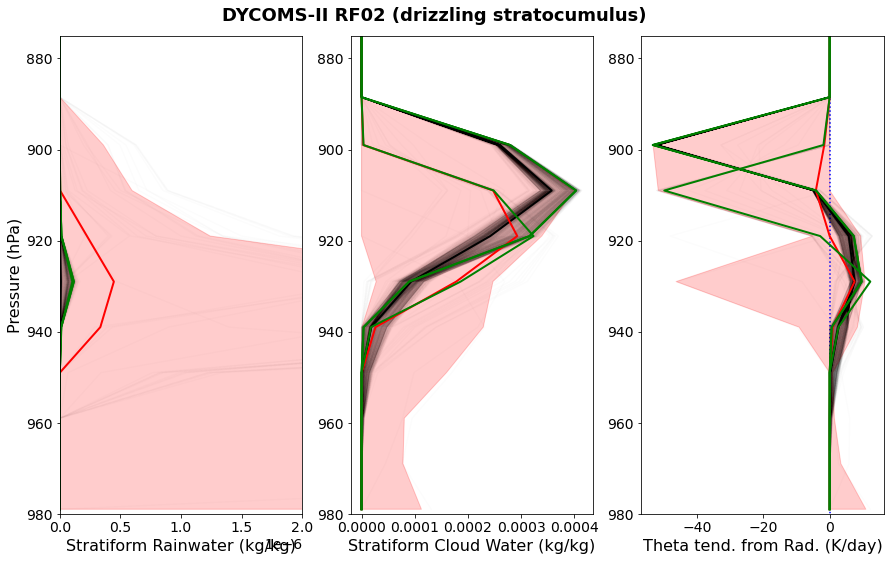

In [219]:
fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(1,3)
ax = fig.add_subplot(gs[0])
stuff = ax.plot(all_qpl,pres,'k',alpha=.01)
ax.fill_betweenx(pres,qpl_pct[2,:], qpl_pct[0,:], color='k',alpha=0.2)
ax.plot(qpl_pct[1,:],pres,'k',lw=2)
ax.fill_betweenx(pres,qpl_post_pct[2,:], qpl_post_pct[0,:], color='r',alpha=0.2)
ax.plot(qpl_post_pct[1,:],pres,'r',lw=2)
ax.plot(all_qpl_post[:,ig1],pres,'g',lw=2)
ax.plot(all_qpl_post[:,ig2],pres,'g',lw=2)
ax.plot(all_qpl_post[:,ig2],pres,'g',lw=2)
ax.invert_yaxis()
ax.set_ylim(980,875)
ax.set_xlim(0.,2.e-6)
ax.set_xlabel('Stratiform Rainwater (kg/kg)',fontsize=16)
ax.set_ylabel('Pressure (hPa)',fontsize=16)
#..
ax = fig.add_subplot(gs[1])
stuff = ax.plot(all_qcl,pres,'k',alpha=.01)
ax.fill_betweenx(pres,qcl_pct[2,:], qcl_pct[0,:], color='k',alpha=0.2)
ax.plot(qcl_pct[1,:],pres,'k',lw=2)
ax.fill_betweenx(pres,qcl_post_pct[2,:], qcl_post_pct[0,:], color='r',alpha=0.2)
ax.plot(qcl_post_pct[1,:],pres,'r',lw=2)
ax.plot(all_qcl_post[:,ig1],pres,'g',lw=2)
ax.plot(all_qcl_post[:,ig2],pres,'g',lw=2)
ax.plot(all_qcl_post[:,ig2],pres,'g',lw=2)
ax.invert_yaxis()
ax.set_ylim(980,875)
#ax.set_xlim(0.,1.e-5)
ax.set_xlabel('Stratiform Cloud Water (kg/kg)',fontsize=16)
#..
ax = fig.add_subplot(gs[2])
ax.plot([0.,0.],[100,1000.],'b:')
stuff = ax.plot(all_dth,pres,'k',alpha=.01)
ax.fill_betweenx(pres,dth_pct[2,:], dth_pct[0,:], color='k',alpha=0.2)
ax.plot(dth_pct[1,:],pres,'k',lw=2)
ax.fill_betweenx(pres,dth_post_pct[2,:], dth_post_pct[0,:], color='r',alpha=0.2)
ax.plot(dth_post_pct[1,:],pres,'r',lw=2)
ax.plot(all_dth_post[:,ig1],pres,'g',lw=2)
ax.plot(all_dth_post[:,ig2],pres,'g',lw=2)
ax.plot(all_dth_post[:,ig2],pres,'g',lw=2)
ax.invert_yaxis()
ax.set_ylim(980,875)
#ax.set_xlim(0.,1.e-5)
ax.set_xlabel('Theta tend. from Rad. (K/day)',fontsize=16)

gs.update(top=.93,bottom=.1,left=.1,right=.98,wspace=.2)

if (case=='dycoms'):
    plt.suptitle('DYCOMS-II RF02 (drizzling stratocumulus)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_dycoms_prof_00.png')
elif (case=='bomex'):
    plt.suptitle('BOMEX (maritime trade Cu)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_bomex_prof_00.png')
elif (case=='rico'):
    plt.suptitle('RICO (trade wind Cu)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_rico_prof_00.png')
    

In [166]:
#...Get precipitation rate histograms
numpar = 45
num_main_ppe = 550
nt     = time.shape[0]
allpar = np.zeros((numpar,num_main_ppe))
all_prec = np.zeros((nt,num_main_ppe))

#..
num_post = 200
allpar_post = np.zeros((numpar,num_post))
all_prec_post = np.zeros((nt,num_post))

#..Now do this for all ensemble members
for i in range(num_main_ppe):
    #..Pick one. First see if we can read parameters
    par_dict = {}
    pars = []
    parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars = np.r_[pars,float(val)]
                    parnames = parnames + [name]
                idict={name:float(val) for name,val in r}
                par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    time = nc.variables['time'][:]
    prec = nc.variables['prec'][:,0,0]
    nc.close()
    #..
    #
    allpar[:,i]   = pars
    all_prec[:,i] = prec
    
#..Now do this for all ensemble members
ii = 0
for i in range(num_main_ppe+100,num_subdir):
    #..Pick one. First see if we can read parameters
    #par_dict = {}
    pars_post = []
    #parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars_post = np.r_[pars_post,float(val)]
                    #parnames = parnames + [name]
                #idict={name:float(val) for name,val in r}
                #par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    time = nc.variables['time'][:]
    prec_post = nc.variables['prec'][:,0,0]
    nc.close()
    #..
    #
    allpar_post[:,ii]   = pars_post
    all_prec_post[:,ii] = prec_post
    ii += 1
    
#..Make histogram bins and save histograms for each run
#..Get the folowing profiels
tidx_start = 10    #..hr 10 if 30 min dt
tidx_end   = 40    #..hr 15 if 30 min dt
prec_bins  = np.arange(0,2.1,.05)

prec_hist = np.zeros((num_main_ppe,prec_bins.shape[0]-1))
prec_post_hist = np.zeros((num_post,prec_bins.shape[0]-1))

for i in range(num_main_ppe):
    prec_hist[i,:],be = np.histogram(all_prec[tidx_start:tidx_end,i],bins=prec_bins)
for i in range(num_post):
    prec_post_hist[i,:],be = np.histogram(all_prec_post[tidx_start:tidx_end,i],bins=prec_bins)


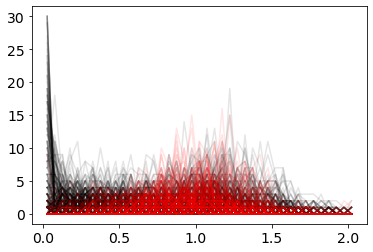

In [167]:
prec_be = 0.5*(prec_bins[1:]-prec_bins[0:-1])+prec_bins[0:-1]
stuff = plt.plot(prec_be,prec_hist.T,'k',alpha=.1)
stuff2 = plt.plot(prec_be,prec_post_hist.T,'r',alpha=.1)

In [168]:
#..Cacalate 90th, 50th, 10th percentile
pctiles = [90,50,10]
prec_hist_pct      = np.percentile(prec_hist,pctiles,axis=0)
prec_post_hist_pct = np.percentile(prec_post_hist,pctiles,axis=0)


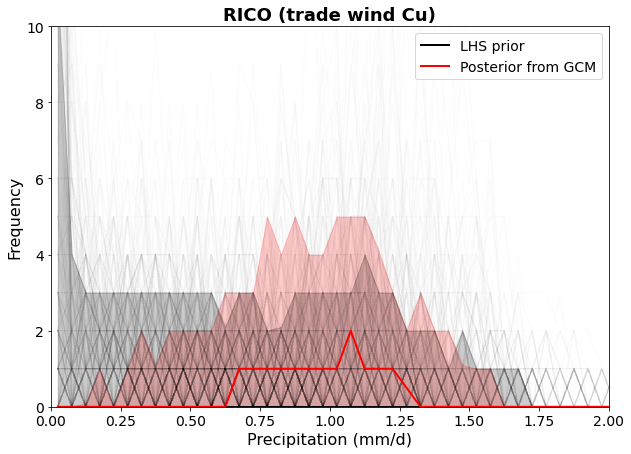

In [169]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
stuff = ax.plot(prec_be,prec_hist.T,'k',alpha=.01)
ax.fill_between(prec_be, prec_hist_pct[2,:], prec_hist_pct[0,:],color='k', alpha=0.2)
ax.plot(prec_be,prec_hist_pct[1,:],'k',lw=2,label='LHS prior')
ax.fill_between(prec_be, prec_post_hist_pct[2,:], prec_post_hist_pct[0,:],color='r', alpha=0.2)
ax.plot(prec_be,prec_post_hist_pct[1,:],'r',lw=2,label='Posterior from GCM')
plt.legend()
ax.set_xlim(0.,2.)
ax.set_ylim(0.,10.)
ax.set_ylabel('Frequency',fontsize=16)
ax.set_xlabel('Precipitation (mm/d)',fontsize=16)

if (case=='dycoms'):
    plt.title('DYCOMS-II RF02 (drizzling stratocumulus)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_dycoms_prechist_00.png')
elif (case=='bomex'):
    plt.title('BOMEX (maritime trade Cu)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_bomex_prechist_00.png')
elif (case=='rico'):
    plt.title('RICO (trade wind Cu)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_rico_prechist_00.png')

In [106]:
#..Down here for the weirder ones (TWP ICE)
#..
#..timeseries of: 
#..  precip
#..  conv/strat precip?
#..  LWP (total, cloud-only)
#..  IWP
#case = 'twpice15mins'
case = 'sparticus'
case_upper = case.upper()
#case_upper = 'TWPICE15mins'

#main_dir = '/home/marcus/marcus_data/E3SM_BOSS_PPE_data/GISS_SCM_PPE/dycoms/'
main_dir = '/data/gelsaess/giss-e3scm-ppe-elsaesser/'+case+'/'
#main_dir = '/Users/marcus/Research/Elsaesser_NASA/SCM_PPE/'+case+'/'
subdir_list = []
num_subdir  = 0
for root,dirs,files in walklevel(main_dir,level=0):
    for dirr in dirs:
        #if dirr.startswith('SCM_'+case_upper+'_jingbo'):
        if dirr.startswith('SCM_'+case_upper+'_gse'):
            subdir_list.append(dirr)
            num_subdir += 1
subdir_list = sorted(subdir_list)
subdir_list = subdir_list[1:]
num_subdir -= 1
print(num_subdir,subdir_list[-1])

850 SCM_SPARTICUS_gse850F110


In [107]:
#..Pick one. First see if we can read parameters
par_dict = {}
pars = []
parnames = list()
with open(main_dir+subdir_list[420]+'/I') as myfile:
    for myline in myfile:
        if (myline[0]==' '):
            pass
        else:
            r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
            for name,val in r:
                if val:
                    pars = np.r_[pars,float(val)]
                parnames = parnames + [name]
            idict={name:float(val) for name,val in r}
            par_dict.update(idict)

In [108]:
print(par_dict)
print(pars.shape)
print(len(parnames))

{'debdecaytime': 2150.66, 'mc': 42.159, 'xs': 110.259, 'qc': 0.000122477, 'multiplier': 0.639139, 'mstcnv': 10.6449, '': 3.31033, 'urelscale': 65.1935, 'dpscale': 64.3072, 'scale': 0.000714371, 'fevapfac': 0.0327813, 'fac': 1.00092, 'max': 113.406, 'detbyent': 0.357525, 'dd': 5.68312e-05, 'overshoot': 0.270718, 'aspcp': 0.139813, 'fddrt': 0.60429, 'tfmc': 255.196, 'env': 5.26882, 'homf': 237.609, 'rhcsl': 0.833764, 'rhctl': 0.932526, 'homfree': 239960.0, 'dcs': 0.000351213, 'rh': 0.970603, 'pow': 0.212904, 'time': 3553.15, 'cn': 0.838203, 'iifn': 8.71985, 'difn': 8.76673, 'ifluffy': 0.19737, 'sfluffy': 0.612629, 'multi': 0.854739, 'mults': 1.25661, 'entrain': 15.1426}
(45,)
45


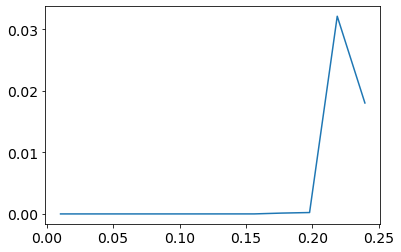

In [109]:
#.. Now let's make a plot or two
idx = 500
#nc = Dataset(main_dir+subdir_list[idx]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(idx+1).zfill(3)+'F110.nc','r')
nc = Dataset(main_dir+subdir_list[idx]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(idx+1).zfill(3)+'F110.nc','r')
time = nc.variables['time'][:]
prec = nc.variables['prec'][:,0,0]
lwp  = nc.variables['lwp'][:,0,0]
nc.close()

plt.plot(time/24.,prec)

In [114]:
#..  precip
#..  conv/strat precip?
#..  LWP (total, cloud-only)
#..  IWP
numpar = 45
num_main_ppe = 550
nt     = time.shape[0]
allpar = np.zeros((numpar,num_main_ppe))
all_prec = np.zeros((nt,num_main_ppe))
all_preccon = np.zeros((nt,num_main_ppe))
all_precstr = np.zeros((nt,num_main_ppe))
all_lwp  = np.zeros((nt,num_main_ppe))
all_iwp  = np.zeros((nt,num_main_ppe))
all_cldtot = np.zeros((nt,num_main_ppe))  #..Total cloud fraction
all_cnvcld = np.zeros((nt,num_main_ppe))  #..convective cloud fraction
all_strcld = np.zeros((nt,num_main_ppe))  #..stratiform cloud fraction
#all_olr = np.zeros((nt,num_main_ppe))
#..
num_post = 200
allpar_post = np.zeros((numpar,num_post))
all_prec_post = np.zeros((nt,num_post))
all_preccon_post = np.zeros((nt,num_post))
all_precstr_post = np.zeros((nt,num_post))
all_lwp_post  = np.zeros((nt,num_post))
all_iwp_post  = np.zeros((nt,num_post))
all_cldtot_post = np.zeros((nt,num_post))
all_cnvcld_post = np.zeros((nt,num_post))
all_strcld_post = np.zeros((nt,num_post))
#all_olr_post = np.zeros((nt,num_post))

#..Now do this for all ensemble members
for i in range(num_main_ppe):
    #..Pick one. First see if we can read parameters
    par_dict = {}
    pars = []
    parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars = np.r_[pars,float(val)]
                    parnames = parnames + [name]
                idict={name:float(val) for name,val in r}
                par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    time = nc.variables['time'][:]
    prec = nc.variables['prec'][:,0,0]
    preccon = nc.variables['mcp'][:,0,0]
    precstr = nc.variables['ssp'][:,0,0]
    lwp  = nc.variables['lwp'][:,0,0]
    iwp  = nc.variables['iwp'][:,0,0]
    cldtot = nc.variables['cldtot_2d'][:,0,0]
    #cnvcld = nc.variables['cldmc_2d'][:,0,0]
    #strcld = nc.variables['cldss_2d'][:,0,0]
    cnvcld = nc.variables['tau_mc'][:,0,0]
    strcld = nc.variables['tau_ss'][:,0,0]
    nc.close()
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    #olr  = nc.variables['olr'][:,0,0]
    #nc.close()
    #
    allpar[:,i]   = pars
    all_prec[:,i] = prec
    all_preccon[:,i] = preccon
    all_precstr[:,i] = precstr
    all_lwp[:,i]  = lwp
    all_iwp[:,i]  = iwp
    all_cldtot[:,i] = cldtot
    all_cnvcld[:,i] = cnvcld
    all_strcld[:,i] = strcld
    #all_olr[:,i]  = olr
    
#..Now do this for all ensemble members
ii = 0
for i in range(num_main_ppe+100,num_subdir):
    #..Pick one. First see if we can read parameters
    #par_dict = {}
    pars_post = []
    #parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars_post = np.r_[pars_post,float(val)]
                    #parnames = parnames + [name]
                #idict={name:float(val) for name,val in r}
                #par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    if (case=='twpice15mins'):
        time = (1/24.)*nc.variables['time'][:]
    else:
        time = nc.variables['time'][:]
    prec_post = nc.variables['prec'][:,0,0]
    preccon_post = nc.variables['mcp'][:,0,0]
    precstr_post = nc.variables['ssp'][:,0,0]
    lwp_post  = nc.variables['lwp'][:,0,0]
    iwp_post  = nc.variables['iwp'][:,0,0]
    cldtot_post = nc.variables['cldtot_2d'][:,0,0]
    #cnvcld_post = nc.variables['cldmc_2d'][:,0,0]
    #strcld_post = nc.variables['cldss_2d'][:,0,0]
    cnvcld_post = nc.variables['tau_mc'][:,0,0]
    strcld_post = nc.variables['tau_ss'][:,0,0]
    nc.close()
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    #olr_post  = nc.variables['olr'][:,0,0]
    #nc.close()
    #
    allpar_post[:,ii]   = pars_post
    all_prec_post[:,ii] = prec_post
    all_preccon_post[:,ii] = preccon_post
    all_precstr_post[:,ii] = precstr_post
    all_lwp_post[:,ii]  = lwp_post
    all_iwp_post[:,ii]  = iwp_post
    all_cldtot_post[:,ii] = cldtot_post
    all_cnvcld_post[:,ii] = cnvcld_post
    all_strcld_post[:,ii] = strcld_post
    #all_olr_post[:,ii]  = olr_post
    ii += 1

In [115]:
#..Cacalate 90th, 50th, 10th percentile
pctiles = [90,50,10]
lwp_pct  = np.percentile(all_lwp,pctiles,axis=1)
iwp_pct  = np.percentile(all_iwp,pctiles,axis=1)
prec_pct = np.percentile(all_prec,pctiles,axis=1)
preccon_pct = np.percentile(all_preccon,pctiles,axis=1)
precstr_pct = np.percentile(all_precstr,pctiles,axis=1)
cldt_pct = np.percentile(all_cldtot,pctiles,axis=1)
#olr_pct  = np.percentile(all_olr,pctiles,axis=1)
cnv_pct  = np.percentile(all_cnvcld,pctiles,axis=1)
str_pct  = np.percentile(all_strcld,pctiles,axis=1)
print(lwp_pct.shape)
#..
lwp_pct_post  = np.percentile(all_lwp_post,pctiles,axis=1)
iwp_pct_post  = np.percentile(all_iwp_post,pctiles,axis=1)
prec_pct_post = np.percentile(all_prec_post,pctiles,axis=1)
preccon_pct_post = np.percentile(all_preccon_post,pctiles,axis=1)
precstr_pct_post = np.percentile(all_precstr_post,pctiles,axis=1)
cldt_pct_post = np.percentile(all_cldtot_post,pctiles,axis=1)
#olr_pct_post  = np.percentile(all_olr_post,pctiles,axis=1)
cnv_pct_post  = np.percentile(all_cnvcld_post,pctiles,axis=1)
str_pct_post  = np.percentile(all_strcld_post,pctiles,axis=1)
print(lwp_pct_post.shape)

(3, 12)
(3, 12)


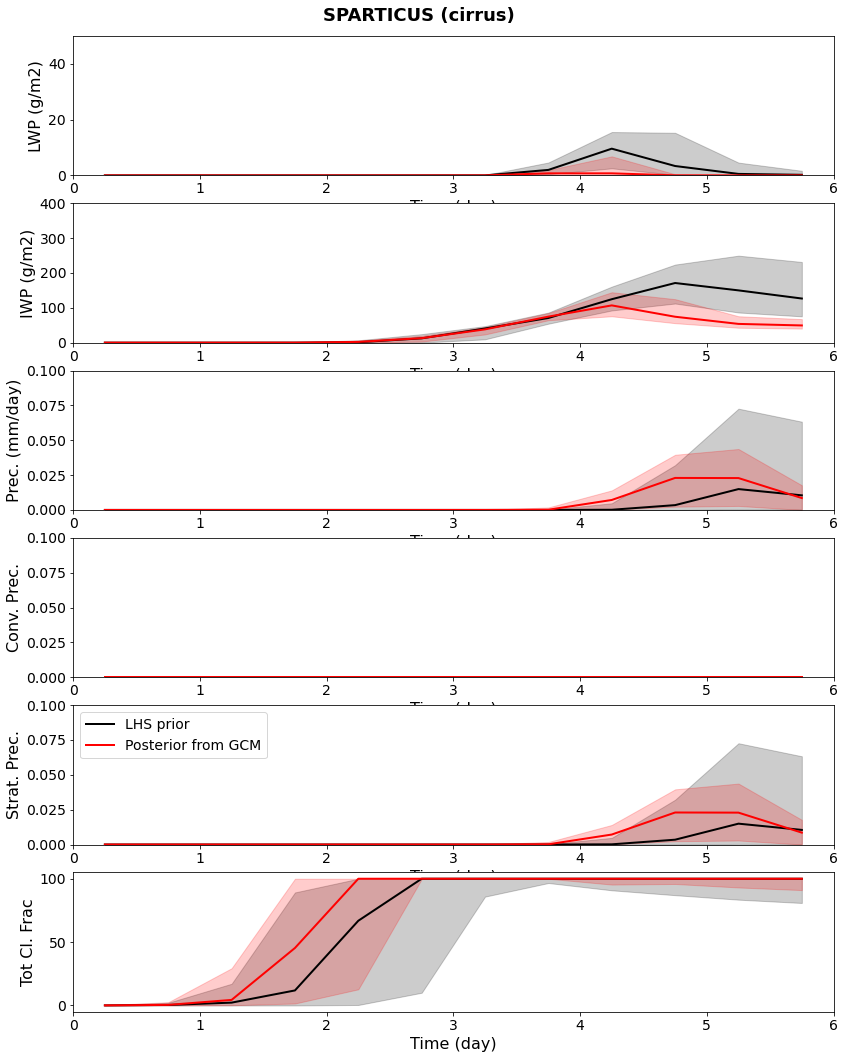

In [126]:
maxt = 16
max_contau=150.
max_strtau = .5
max_iwp = 100.
if (case=='rico' or case=='bomex'):
    fig = plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(3,2)
    max_lwp = 100.
    max_prec = 3.
elif (case=='sct'):
    fig = plt.figure(figsize=(15,15))
    #fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(3,2)
    #gs = gridspec.GridSpec(2,2)
    max_lwp = 150.
    max_prec = 3.
    maxt=72
    max_contau=30.
    max_strtau = .01
elif (case=='twpice15mins'):
    fig = plt.figure(figsize=(12,20))
    gs = gridspec.GridSpec(8,1)
    max_lwp = 5000.
    max_iwp = 4000.
    max_prec= 150.
    maxt = 16.
    max_contau = 1000.
    max_strtau = 130.
elif (case=='sparticus'):
    fig = plt.figure(figsize=(12,20))
    gs = gridspec.GridSpec(8,1)
    max_lwp = 50.
    max_iwp = 400.
    max_prec= 0.1
    maxt = 6.
    max_contau = 10.
    max_strtau = 1.
else:
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(2,2)
    max_lwp = 200.
    max_prec = 1.
    
#
ax = fig.add_subplot(gs[0])
#stuff = ax.plot(time,all_lwp,'k',alpha=.01)
ax.fill_between(time, lwp_pct[2,:], lwp_pct[0,:],color='k', alpha=0.2)
ax.plot(time,lwp_pct[1,:],'k',lw=2)
ax.fill_between(time, lwp_pct_post[2,:], lwp_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,lwp_pct_post[1,:],'r',lw=2)
ax.set_xlim(0.,maxt)
ax.set_ylim(0.,max_lwp)
ax.set_ylabel('LWP (g/m2)',fontsize=16)
ax.set_xlabel('Time (day)',fontsize=16)
#
ax = fig.add_subplot(gs[1])
#stuff = ax.plot(time,all_iwp,'k',alpha=.01)
ax.fill_between(time, iwp_pct[2,:], iwp_pct[0,:],color='k', alpha=0.2)
ax.plot(time,iwp_pct[1,:],'k',lw=2)
ax.fill_between(time, iwp_pct_post[2,:], iwp_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,iwp_pct_post[1,:],'r',lw=2)
ax.set_xlim(0.,maxt)
ax.set_ylim(0.,max_iwp)
ax.set_ylabel('IWP (g/m2)',fontsize=16)
ax.set_xlabel('Time (day)',fontsize=16)
#
ax = fig.add_subplot(gs[2])
#stuff = ax.plot(time,all_prec,'k',alpha=.01)
ax.fill_between(time, prec_pct[2,:], prec_pct[0,:], color='k',alpha=0.2)
ax.plot(time,prec_pct[1,:],'k',lw=2,label='LHS prior')
ax.fill_between(time, prec_pct_post[2,:], prec_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,prec_pct_post[1,:],'r',lw=2,label='Posterior from GCM')
ax.set_ylim(0,max_prec)
ax.set_xlim(0.,maxt)
ax.set_ylabel('Prec. (mm/day)',fontsize=16)
ax.set_xlabel('Time (day)',fontsize=16)
#ax.legend(fontsize=14)
#
ax = fig.add_subplot(gs[3])
#stuff = ax.plot(time,all_preccon,'k',alpha=.01)
ax.fill_between(time, preccon_pct[2,:], preccon_pct[0,:], color='k',alpha=0.2)
ax.plot(time,preccon_pct[1,:],'k',lw=2,label='LHS prior')
ax.fill_between(time, preccon_pct_post[2,:], preccon_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,preccon_pct_post[1,:],'r',lw=2,label='Posterior from GCM')
ax.set_ylim(0,max_prec)
ax.set_xlim(0.,maxt)
ax.set_ylabel('Conv. Prec.',fontsize=16)
ax.set_xlabel('Time (day)',fontsize=16)
#ax.legend(fontsize=14)
#
ax = fig.add_subplot(gs[4])
#stuff = ax.plot(time,all_precstr,'k',alpha=.01)
ax.fill_between(time, precstr_pct[2,:], precstr_pct[0,:], color='k',alpha=0.2)
ax.plot(time,precstr_pct[1,:],'k',lw=2,label='LHS prior')
ax.fill_between(time, precstr_pct_post[2,:], precstr_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,precstr_pct_post[1,:],'r',lw=2,label='Posterior from GCM')
ax.set_ylim(0,max_prec)
ax.set_xlim(0.,maxt)
ax.set_ylabel('Strat. Prec.',fontsize=16)
ax.set_xlabel('Time (day)',fontsize=16)
ax.legend(fontsize=14,loc=2)
#
ax = fig.add_subplot(gs[5])
#stuff = ax.plot(time,all_cldtot,'k',alpha=.01)
ax.fill_between(time, cldt_pct[2,:], cldt_pct[0,:], color='k',alpha=0.2)
ax.plot(time,cldt_pct[1,:],'k',lw=2)
ax.fill_between(time, cldt_pct_post[2,:], cldt_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,cldt_pct_post[1,:],'r',lw=2)
ax.set_xlim(0.,maxt)
ax.set_ylabel('Tot Cl. Frac',fontsize=16)
ax.set_xlabel('Time (day)',fontsize=16)
#..
# ax = fig.add_subplot(gs[3])
# stuff = ax.plot(time,all_olr,'k',alpha=.01)
# ax.fill_between(time, olr_pct[2,:], olr_pct[0,:], alpha=0.2)
# ax.plot(time,olr_pct[1,:],'k',lw=2)
# ax.fill_between(time, olr_pct_post[2,:], olr_pct_post[0,:],color='r', alpha=0.2)
# ax.plot(time,olr_pct_post[1,:],'r',lw=2)
# ax.set_xlim(0.,maxt)
# ax.set_ylabel('OLR (W/m2)',fontsize=16)
# ax.set_xlabel('Time (hr)',fontsize=16)
#..
if (case=='twpice15mins'):
    #
    ax = fig.add_subplot(gs[6])
    #stuff = ax.plot(time,all_cnvcld,'k',alpha=.01)
    ax.fill_between(time, cnv_pct[2,:], cnv_pct[0,:], color='k',alpha=0.2)
    ax.plot(time,cnv_pct[1,:],'k',lw=2)
    ax.fill_between(time, cnv_pct_post[2,:], cnv_pct_post[0,:],color='r', alpha=0.2)
    ax.plot(time,cnv_pct_post[1,:],'r',lw=2)
    ax.set_xlim(0.,maxt)
    ax.set_ylim(0.,max_contau)
    ax.set_ylabel('Conv. Tau',fontsize=16)
    ax.set_xlabel('Time (day)',fontsize=16)
    #..
    ax = fig.add_subplot(gs[7])
    #stuff = ax.plot(time,all_strcld,'k',alpha=.01)
    ax.fill_between(time, str_pct[2,:], str_pct[0,:], color='k', alpha=0.2)
    ax.plot(time,str_pct[1,:],'k',lw=2)
    ax.fill_between(time, str_pct_post[2,:], str_pct_post[0,:],color='r', alpha=0.2)
    ax.plot(time,str_pct_post[1,:],'r',lw=2)
    ax.set_xlim(0.,maxt)
    ax.set_ylim(0.,max_strtau)
    ax.set_ylabel('Strat. Tau',fontsize=16)
    ax.set_xlabel('Time (day)',fontsize=16)
#..
gs.update(top=.96,bottom=.05,left=.1,right=.98)
#..
if (case=='dycoms'):
    plt.suptitle('DYCOMS-II RF02 (drizzling stratocumulus)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_dycoms_ts_00.png')
elif (case=='bomex'):
    plt.suptitle('BOMEX (maritime trade Cu)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_bomex_ts_00.png')
elif (case=='rico'):
    plt.suptitle('RICO (trade wind Cu)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_rico_ts_00.png')
elif (case=='sct'):
    plt.suptitle('Sc to Cu transition',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_sct_ts_00.png')
elif (case=='twpice15mins'):
    plt.suptitle('TWP-ICE (deep convection)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_twpice_ts_00.png')
elif (case=='sparticus'):
    plt.suptitle('SPARTICUS (cirrus)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_sparticus_ts_00.png')